# Inference with exported learner

In [ ]:
#all_skip
from fastMONAI.vision_all import *


from monai.apps import DecathlonDataset

In [ ]:
tasks = {
    "brain": "Task01_BrainTumour",
    "heart": "Task02_Heart", 
    "spleen": "Task09_Spleen"
}

task = tasks["heart"]

model_artifact_path = Path(f"model_artifacts/{task}")

In [ ]:
path = Path('../data')
path.mkdir(exist_ok=True)

In [ ]:
test_data = DecathlonDataset(root_dir=path, task=task, section="test", download=True,
                                 cache_num=0, num_workers=3) 

2025-08-27 10:30:03,379 - INFO - Verified 'Task02_Heart.tar', md5: 06ee59366e1e5124267b774dbd654057.
2025-08-27 10:30:03,380 - INFO - File exists: ../data/Task02_Heart.tar, skipped downloading.
2025-08-27 10:30:03,381 - INFO - Non-empty folder exists in ../data/Task02_Heart, skipped extracting.


In [ ]:
test_imgs = [data['image'] for data in test_data.data]

In [ ]:
import mlflow
from mlflow.tracking import MlflowClient

client = MlflowClient()
experiment = mlflow.get_experiment_by_name(task)

# Get latest run
runs = mlflow.search_runs(
    experiment_ids=[experiment.experiment_id],
    order_by=["start_time DESC"], 
    max_results=1
)

latest_run_id = runs.iloc[0].run_id
print(f"Loading artifacts from run: {latest_run_id}")

# Download artifacts
learner_path = client.download_artifacts(latest_run_id, "model/learner.pkl")
config_path = client.download_artifacts(latest_run_id, "config/inference_settings.pkl")

Loading artifacts from run: 65bbdbdb1906427f989d821b8993cd41


In [ ]:
learn_inf = load_learner(learner_path, cpu=False);

load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.


In [ ]:
print(learn_inf.dls.after_item)

Pipeline: ZNormalization -- {}
 -> PadOrCrop -- {}
 -> RandomAffine -> ToTensor


In [ ]:
item_transforms = learn_inf.dls.after_item


Transform at index 0: <class 'fastMONAI.vision_augmentation.ZNormalization'>


AttributeError: 'ZNormalization' object has no attribute 'mean'

In [ ]:
_, reorder, resample = load_variables(pkl_fn=config_path)
reorder, resample

(False, [1.25, 1.25, 1.37])

In [ ]:
save_path = Path(f'../data/{task}/pred_masks')
save_path.mkdir(parents=True, exist_ok=True)

In [ ]:
idx = 3
img_fn = test_imgs[idx]
img_fn

'../data/Task02_Heart/imagesTs/la_001.nii.gz'

In [ ]:
pred_fn = inference(learn_inf, reorder=reorder, resample=resample, fn=img_fn, save_path=save_path)

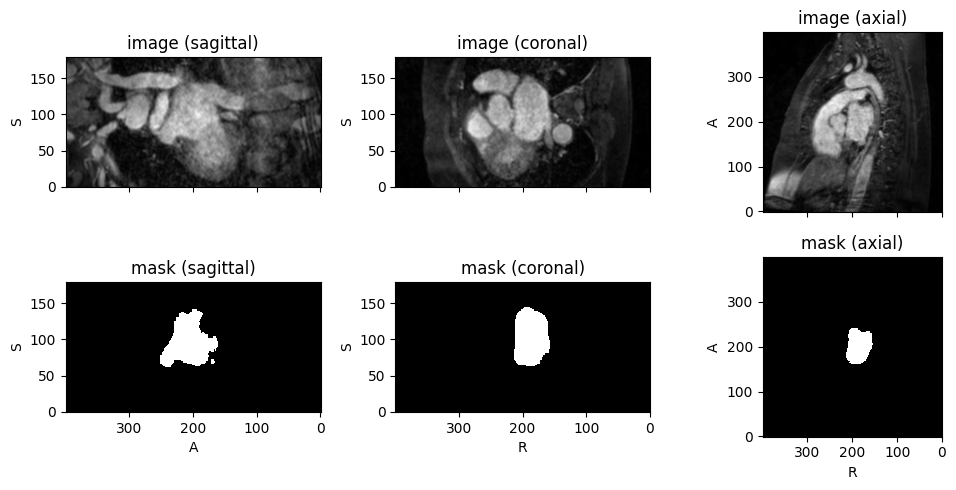

In [ ]:
from torchio import Subject, ScalarImage, LabelMap

subject = Subject(image=ScalarImage(img_fn), mask=LabelMap(pred_fn))
subject.plot(figsize=(10,5))